In [28]:
import tensorflow as tf
import numpy as np
import csv
from matplotlib import pyplot as plt
import pandas as pd
import pickle
import RomObject

In [29]:
#this is a little inefficient (hacky) right now, but I'm trying to make it work
#with some really old files from my archive
design_data = pd.read_csv('originalNzlVelocity_25.dat', dtype='float64', delimiter=' ', skiprows=1, nrows=1, header=None)
designs = design_data.values
print(designs)
#pickle the designs
with open('designs.pkl', 'wb') as output:
    pickle.dump(designs, output, pickle.HIGHEST_PROTOCOL)

#read in a data frame using pandas
pd_data = pd.read_csv('originalNzlVelocity_25.dat', dtype='float64', delimiter='\t', skiprows=4)
#make it an np ndarray
data = pd_data.values

[[ 10.9728  11.7689  12.5651  13.3612  14.1574  14.9535  15.7496  16.5458
   17.3419  18.138   18.9342  19.7303  20.5265  21.3226  22.1187  22.9149
   23.711   24.5071  25.3033  26.0994  26.8956  27.6917  28.4878  29.284
   30.4782]]


In [30]:
shp = data.shape
#remove the column that's in a NaN
data = np.delete(data,shp[1]-1,axis=1)
print(data)

[[ -3.95355000e-05  -4.18635000e-05  -4.41570000e-05 ...,  -8.67479000e-05
   -8.87769000e-05  -9.17878000e-05]
 [  1.09733000e+01   1.17694000e+01   1.25657000e+01 ...,   2.84889000e+01
    2.92851000e+01   3.04794000e+01]
 [ -9.74409000e-06  -1.07593000e-05  -1.18931000e-05 ...,  -3.91785000e-05
   -4.09716000e-05  -4.33927000e-05]
 ..., 
 [ -5.50177000e-02  -5.90862000e-02  -6.31415000e-02 ...,  -1.40180000e-01
   -1.43978000e-01  -1.49532000e-01]
 [ -5.14388000e-03  -5.52427000e-03  -5.90343000e-03 ...,  -1.31061000e-02
   -1.34612000e-02  -1.39805000e-02]
 [ -8.76162000e-03  -8.15451000e-03  -6.76377000e-03 ...,   3.79619000e-02
    4.16986000e-02   4.71553000e-02]]


In [31]:
print(data.shape)

(195752, 25)


In [32]:
#create tensor from data-frame
data_tensor = tf.constant(data, dtype=tf.float64, shape=[data.shape[0], data.shape[1]])
print(data_tensor.get_shape)

<bound method Tensor.get_shape of <tf.Tensor 'Const_1:0' shape=(195752, 25) dtype=float64>>


In [33]:
#mean center the data
mean_array = None
mean_data_tensor = tf.reduce_mean(data_tensor, axis=1, keep_dims=True)
print(mean_data_tensor)

Tensor("Mean_2:0", shape=(195752, 1), dtype=float64)


In [34]:
print(data_tensor.shape)
assert( data.shape == data_tensor.shape)

(195752, 25)


In [35]:
#compute the SVD
#DONT SET full_matrices to True unless you have a ton of memory on your GPU
#can also compute the SVD of the covariance matrix
#svd_out = tf.svd(data, compute_uv=True, full_matrices=False, name="svd")
svd_out = tf.svd(tf.subtract(data,mean_data_tensor), compute_uv=True, full_matrices=False, name="svd")

In [36]:
with tf.Session() as sess:
    mean_array = mean_data_tensor.eval()
    s, u, v = sess.run(svd_out)
    #Compute coefficients
    compute_coeffs = tf.matmul(tf.transpose(u), tf.subtract(data,mean_data_tensor))
    #compute energy of the POD expansion
    e = sess.run(tf.reduce_sum(s))
    s_energy = sess.run(tf.div(s,e)*100)
    coeffs = sess.run(compute_coeffs)

In [37]:
print('Raw s-matrix')
print(s)
print('Cumulative Energy')
print(e)
print('Normalized Energy')
print(s_energy)

Raw s-matrix
[  1.74719281e+03   1.23564920e+01   7.48390686e+00   1.66008850e+00
   9.99869081e-01   6.89441244e-01   3.17435744e-01   1.77054696e-01
   1.41115942e-01   9.52668322e-02   8.17950605e-02   7.54547233e-02
   5.52999803e-02   4.73342370e-02   4.38217848e-02   4.01197654e-02
   3.55495011e-02   3.15459780e-02   2.28079767e-02   2.15063362e-02
   1.79061987e-02   1.40585349e-02   1.13570371e-02   9.58664157e-03
   1.49758486e-11]
Cumulative Energy
1771.62162849
Normalized Energy
[  9.86211043e+01   6.97467890e-01   4.22432575e-01   9.37044609e-02
   5.64380715e-02   3.89158290e-02   1.79178070e-02   9.99393396e-03
   7.96535441e-03   5.37738029e-03   4.61695992e-03   4.25907666e-03
   3.12143290e-03   2.67180284e-03   2.47354086e-03   2.26457866e-03
   2.00660799e-03   1.78062728e-03   1.28740677e-03   1.21393507e-03
   1.01072365e-03   7.93540485e-04   6.41053195e-04   5.41122406e-04
   8.45318680e-13]


In [38]:
plt.yscale('log')
plt.plot(s_energy)
plt.plot(s_energy,'ro')
plt.grid()
plt.xlim([-1,shp[1]+1])
plt.xlabel('Mode #');
plt.ylabel('Contribution');
plt.title('Energy Contribution by each mode');

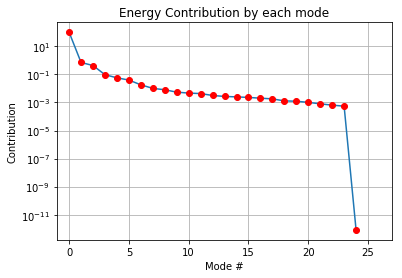

In [39]:
plt.show()
#log scale on the y-axis
#linear scale on the x-axis

In [13]:
#some assertions for correctness
#UU^T = I
uut = np.matmul(np.transpose(u),u)
np.testing.assert_almost_equal(uut, np.eye(u.shape[1],u.shape[1]))
#VV^T = I
vvt = np.matmul(np.transpose(v),v)
np.testing.assert_almost_equal(uut, np.eye(v.shape[1],v.shape[1]))

In [14]:
print(u.shape)
print(v.shape)
print(s.shape)

(195752, 25)
(25, 25)
(25,)


In [15]:
print(coeffs.shape)
print(coeffs.dtype)
print(compute_coeffs)

(25, 25)
float64
Tensor("MatMul:0", shape=(25, 25), dtype=float64)


In [27]:
#SAVE coefficients (coeffs) , left-eigenvectors (u) and singular values (s)
rom_object = RomObject.romobject(u, s_energy, coeffs, mean_array)
with open('rom-object.pkl', 'wb') as output:
    pickle.dump(rom_object, output, pickle.HIGHEST_PROTOCOL)